In [1]:
#Getting redshift data

import pandas as pd

data = pd.read_csv("Skyserver_SQL12_3_2019 6_20_09AM.csv")
objclass = data["class"]
objredshift = data["redshift"]
objra = data["ra"]
objdec = data["dec"]

zarr1 = [] #1 denotes redshifts 0.1 to 0.2
ra1 = []
dec1 = []
for i in range(len(objclass)):
    if ((objclass[i] == "GALAXY") and (0.1 <= objredshift[i] < 0.2) and (110 <= objra[i] <= 270) and (-5 <= objdec[i] <= 70)):
        zarr1.append(float(objredshift[i]))
        ra1.append(float(objra[i]))
        dec1.append(float(objdec[i]))

In [12]:
#Distance between galaxies using approximations in paper

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.constants import c

H0 = 100.
z_c = 3.79
Om, Or, Od, Ok = 0.275, 0., 0.725, 0.

def Ez(z_):
    E = (1. - z/z_c) * np.exp(-z/z_c)
    return 1./E

def comodis(z): #comoving distance
    return z*np.exp(-z/z_c)

def d_calc(z1, z2, alpha): #Eqn (3)
    chiz1 = comodis(z1)
    chiz2 = comodis(z2)
    chimul = chiz1 * chiz2
    d_z = abs(chiz1 - chiz2)
    d_alpha = 2.* np.sin(alpha/2.) * np.sqrt(chimul) * (1. + 1./6 * Ok * chimul)
    d = np.sqrt(d_alpha**2. + d_z**2.)
    dprime = c/H0 * d
    darr = [d_alpha, d_z, d]
    return (darr, dprime)

#Binning of "d"
binspace = 0.0005
dbins = np.arange(0.01, 0.06, binspace)
#dhist1, dhist2, dhist3 = {}, {}, {}
dhist11, dhist22, dhist33 = [], [], []
'''
for i in range(len(dbins)):
    dhist1[dbins[i]+binspace/2.] = 0
    dhist2[dbins[i]+binspace/2.] = 0
    dhist3[dbins[i]+binspace/2.] = 0
'''

def d_hist(z1, z2, alpha):
    dval = d_calc(z1, z2, alpha)
    if (dval[0][1]/dval[0][0] < 1./3):
        dhist11.append(dval[0][2])
        '''
        for i in range(len(dbins)-1):
            if (dbins[i] <= dval[0][2] < dbins[i+1]):
                dhist1[dbins[i]+binspace/2.] += 1
                continue
        '''
    if (dval[0][0]/dval[0][1] < 1./3):
        dhist22.append(dval[0][2])
    else:
        dhist33.append(dval[0][2])

#zarr = np.linspace(0.1, 0.7, 1000)
#alphaarr = np.linspace(np.pi/30., np.pi/40., 1000)
zarr = zarr1[:5000]
for i in range(len(zarr)):
    for j in range(len(zarr)):
        if (i == j): continue
        z1, z2 = zarr[i], zarr[j]
        alpha = np.sqrt(((ra1[i]-ra1[j])*np.cos(dec1[j]))**2. + (dec1[i]-dec1[j])**2.)
        if (alpha > 1.01): continue
        d_hist(z1, z2, alpha)

C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars


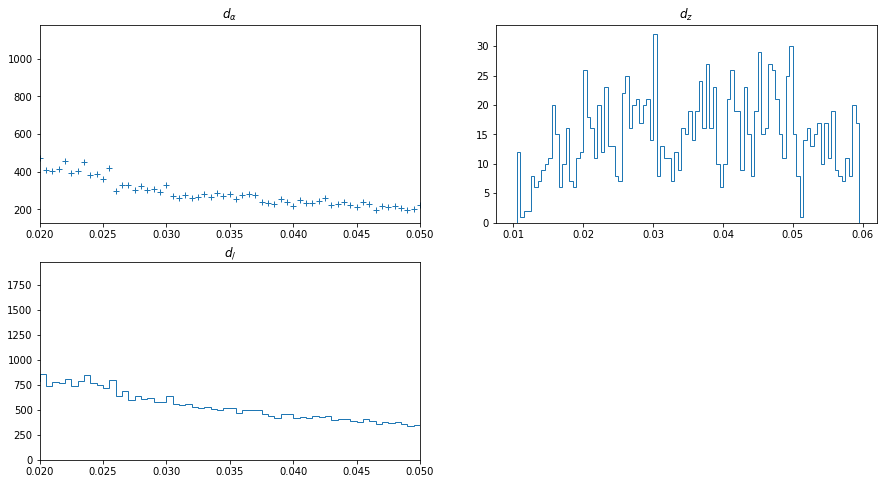

In [13]:
counts11, bins1 = np.histogram(dhist11, dbins)
#plt.hist(bins[:-1], bins, weights=counts*(0.033/bins)**2.)
counts33, bins3 = np.histogram(dhist33, dbins)

fig = plt.figure(figsize = [15, 8])
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
#ax1.hist(dhist11, dbins, histtype='step')
#ax1.hist(bins1[:-1], bins1, weights=counts11*(0.033/bins1[:-1])**2., histtype='step')
ax1.plot(bins1[:-1], counts11*(0.033/bins1[:-1])**2., '+')
ax1.set_title(r'$d_\alpha$')
ax1.set_xlim([0.02, 0.05])
ax2.hist(dhist22, dbins, histtype='step')
ax2.set_title(r'$d_z$')
#ax3.hist(dhist33, dbins, histtype='step')
ax3.hist(bins3[:-1], bins3, weights=counts33*(0.033/bins3[:-1])**2., histtype='step')
ax3.set_title(r'$d_/$')
ax3.set_xlim([0.02, 0.05])
fig.show()